# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at 

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [2]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#os.chdir('task-geo')
#make install
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv

--2020-04-23 00:16:30--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.108.153, 185.199.111.153, 185.199.110.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30815054 (29M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  29.39M  38.3MB/s    in 0.8s    

2020-04-23 00:16:31 (38.3 MB/s) - ‘coronavirus_timeseries.csv’ saved [30815054/30815054]



In [3]:
import pandas as pd
df = pd.read_csv("coronavirus_timeseries.csv")
df[:-20].tail()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,level,city,county,state,country,population,lat,long,url,aggregate,tz,cases,deaths,recovered,active,tested,hospitalized,discharged,growthFactor,date
126840,"Yamagata Prefecture, Japan",state,NaN,NaN,Yamagata Prefecture,Japan,1077057.0,38.4335,140.0910,https://services8.arcgis.com/JdxivnCyd1rvJTrY/...,NaN,Asia/Tokyo,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-20
126841,"Yamagata Prefecture, Japan",state,NaN,NaN,Yamagata Prefecture,Japan,1077057.0,38.4335,140.0910,https://services8.arcgis.com/JdxivnCyd1rvJTrY/...,NaN,Asia/Tokyo,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-21
126842,"Yamanashi Prefecture, Japan",state,NaN,NaN,Yamanashi Prefecture,Japan,812056.0,35.5695,138.6575,https://services8.arcgis.com/JdxivnCyd1rvJTrY/...,NaN,Asia/Tokyo,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-16
126843,"Yamanashi Prefecture, Japan",state,NaN,NaN,Yamanashi Prefecture,Japan,812056.0,35.5695,138.6575,https://services8.arcgis.com/JdxivnCyd1rvJTrY/...,NaN,Asia/Tokyo,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-17
126844,"Yamanashi Prefecture, Japan",state,NaN,NaN,Yamanashi Prefecture,Japan,812056.0,35.5695,138.6575,https://services8.arcgis.com/JdxivnCyd1rvJTrY/...,NaN,Asia/Tokyo,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-18


In [4]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df.tail()

,name,level,city,county,state,country,population,lat,long,url,aggregate,tz,cases,deaths,recovered,active,tested,hospitalized,discharged,growthFactor,date
86,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4935.0,0.0,0.0,0.0,0.0,1922.0,1447.0,0.0,2020-04-17
87,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4993.0,0.0,0.0,0.0,0.0,1943.0,1501.0,0.0,2020-04-18
88,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5026.0,0.0,0.0,0.0,0.0,1981.0,1520.0,0.0,2020-04-19
89,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5027.0,0.0,0.0,0.0,0.0,1999.0,1547.0,0.0,2020-04-20
90,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5027.0,0.0,0.0,0.0,0.0,1999.0,1547.0,0.0,2020-04-21


## Data Augmentation

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug.shape
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
b = a
s = a.fit_transform(antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']])
result = b.fit_transform(antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']][:-20])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
from sklearn.preprocessing import RobustScaler
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'cases']][:70]
x_train_full['cases'] = r.fit_transform(x_train_full['cases'].values.reshape(-1, 1))
y_train_full = x_train_full['cases']
r_test = RobustScaler()
test = antwerp_df[['deaths', 'cases']][70:] 
test['cases'] = r_test.fit_transform(antwerp_df['cases'][70:].values.reshape(-1, 1))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, Y_train = create_dataset(x_train_full, y_train_full, 5)
X_test, y_test = create_dataset(test, test.cases, 5)

In [57]:
import keras
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=2,
    validation_split=0.1,
    shuffle=False
)

Train on 58 samples, validate on 7 samples
Epoch 1/30
58/58 [==============================] - 1s 20ms/step - loss: 0.8647 - val_loss: 37.8788
Epoch 2/30
58/58 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 5.6578
Epoch 3/30
58/58 [==============================] - 0s 4ms/step - loss: 0.0277 - val_loss: 3.4270
Epoch 4/30
58/58 [==============================] - 0s 4ms/step - loss: 0.0440 - val_loss: 4.4734
Epoch 5/30
58/58 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 2.2835
Epoch 6/30
58/58 [==============================] - 0s 4ms/step - loss: 0.5905 - val_loss: 26.4098
Epoch 7/30
58/58 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 7.1021
Epoch 8/30
58/58 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 5.3730
Epoch 9/30
58/58 [==============================] - 0s 4ms/step - loss: 0.0728 - val_loss: 8.3558
Epoch 10/30
58/58 [==============================] - 0s 4ms/step - loss:

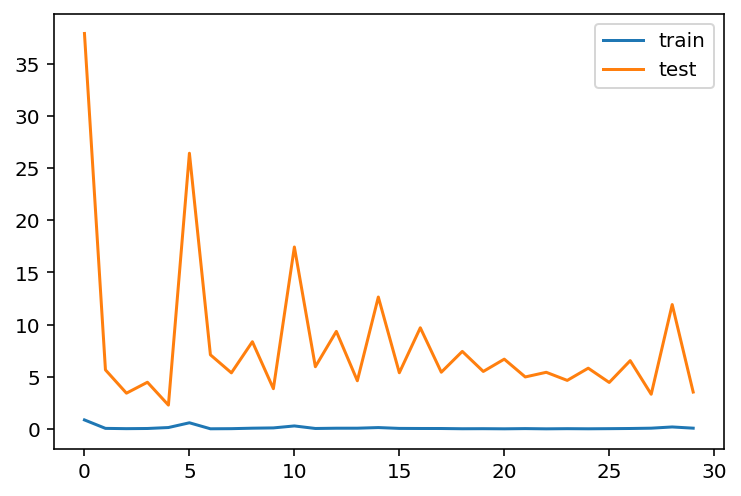

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

array([[   0., 2341.,    0., 2507.,    0., 2693.,    0., 2801.,    0.,
        2880.,    0., 2507.,    0., 2693.,    0., 2801.,    0., 2880.,
           0., 3127.,    0., 2693.,    0., 2801.,    0., 2880.,    0.,
        3127.,    0., 3306.,    0., 2801.,    0., 2880.,    0., 3127.,
           0., 3306.,    0., 3517.,    0., 2880.,    0., 3127.,    0.,
        3306.,    0., 3517.,    0., 3818.,    0., 3127.,    0., 3306.,
           0., 3517.,    0., 3818.,    0., 4081.,    0., 3306.,    0.,
        3517.,    0., 3818.,    0., 4081.,    0., 4172.,    0., 3517.,
           0., 3818.,    0., 4081.,    0., 4172.,    0., 4256.,    0.,
        3818.,    0., 4081.,    0., 4172.,    0., 4256.,    0., 4321.,
           0., 4081.,    0., 4172.,    0., 4256.,    0., 4321.,    0.,
        4461.,    0., 4172.,    0., 4256.,    0., 4321.,    0., 4461.,
           0., 4636.,    0., 4256.,    0., 4321.,    0., 4461.,    0.,
        4636.,    0., 4827.,    0., 4321.,    0., 4461.,    0., 4636.,
      

In [0]:
res = r_test.inverse_transform(model.predict(X_test).reshape(1, -1))
#model.predict(X_test)



In [90]:
r_test.inverse_transform(y_test.reshape(1, -1))

array([[3127., 3306., 3517., 3818., 4081., 4172., 4256., 4321., 4461.,
        4636., 4827., 4935., 4993., 5026., 5027., 5027.]])

In [92]:
res

array([[2046.5496, 2219.8872, 2408.5703, 2622.56  , 2896.1558, 3226.226 ,
        3543.392 , 3834.6094, 4073.2122, 4262.811 , 4441.9688, 4663.839 ,
        4908.366 , 5150.107 , 5349.8877, 5484.2275]], dtype=float32)

### PyTorch models


In [0]:
import torch
import math
from torch.nn.modules import Transformer, TransformerEncoder, TransformerDecoder, TransformerDecoderLayer, TransformerEncoderLayer, LayerNorm
class CustomTransformerDecoder(torch.nn.Module):
    def __init__(self, seq_length, output_seq_length, n_time_series, d_model=128, output_dim=1):
        super().__init__()
        self.dense_shape = torch.nn.Linear(n_time_series, d_model)
        self.pe = SimplePositionalEncoding(d_model)
        encoder_layer = TransformerEncoderLayer(d_model, 8)
        encoder_norm = LayerNorm(d_model)
        self.transformer_enc = TransformerEncoder(encoder_layer, 6, encoder_norm)
        self.output_dim_layer = torch.nn.Linear(d_model, output_dim)
        self.output_seq_length = output_seq_length
        self.out_length_lay  = torch.nn.Linear(seq_length, output_seq_length)
        self.mask = generate_square_subsequent_mask(seq_length)
    def forward(self, x):
        """"""
        x = self.dense_shape(x)
        x = self.pe(x)
        x = x.permute(1,0,2)
        x = self.transformer_enc(x, mask=self.mask)
        x = self.output_dim_layer(x)
        x = x.permute(1, 2, 0)
        x = self.out_length_lay(x)
        return x.view(-1, self.output_seq_length)
    
class SimplePositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(SimplePositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        """Creates a basic positional encoding"""
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
        
def generate_square_subsequent_mask(sz:int)->torch.Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [0]:
c = CustomTransformerDecoder(50, 1, 3)

In [0]:
c(torch.rand(2, 50, 3))

tensor([[0.0163],
        [0.1018]], grad_fn=<ViewBackward>)

In [0]:
class LSTMForecast(torch.nn.Module):
    """
    A very simple baseline LSTM model that returns
    the fixed value based on the input sequence.
    """
    def __init__(self, seq_length: int, n_time_series: int, output_seq_len=1, hidden_states=20, num_layers=2, bias=True):
        super.__init__()
        self.forecast_history = seq_length
        self.n_time_series = n_time_series
        self.lstm = torch.nn.LSTM(n_time_series, hidden_states, num_layers, bias, batch_first=True)
        self.final_layer = torch.nn.Linear(seq_length*hidden_states, output_seq_len)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len , = x.size()
        out_x, hidden_states = self.lstm()
        x = self.final_layer(out_x.contiguous().view(batch_size, -1))

In [0]:
LSTMForecast(10, 3)

TypeError: ignored

In [0]:
class LSTMForecast(torch.nn.Module):
  def __init__(self, seq_length: int, n_time_series: int, output_seq_len=1, hidden_states=20, num_layers=2, bias=True):
    super().__init__()
    self.num_layers = num_layers
    self.forecast_history = seq_length
    self.n_time_series = n_time_series
    self.hidden_dim = hidden_states
    self.lstm = torch.nn.LSTM(n_time_series, hidden_states, num_layers, bias, batch_first=True)
    self.final_layer = torch.nn.Linear(seq_length*hidden_states, output_seq_len)

  def init_hidden(self, batch_size):
    # even with batch_first = True this remains same as docs
    hidden_state = torch.zeros(self.num_layers,batch_size,self.hidden_dim)
    cell_state = torch.zeros(self.num_layers,batch_size,self.hidden_dim)
    self.hidden = (hidden_state, cell_state)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    print(x.size()[0])
    batch_size = x.size()[0]
    out_x,self.hidden = self.lstm(x, self.hidden)
    x = self.final_layer(out_x.contiguous().view(batch_size, -1))
    return x